# Imports

In [51]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import StandardScaler

from uta_gms import read_csv, uta_gms, Criterion

# Read data

In [30]:
df, CRITERIA = read_csv("data/s2.csv")
print(CRITERIA)
df

[Criterion(name='g1', type=True, points=2), Criterion(name='g2', type=True, points=2), Criterion(name='g3', type=True, points=2), Criterion(name='g4', type=True, points=2), Criterion(name='g5', type=True, points=2)]


,g1,g2,g3,g4,g5
a01,-18342,-30.7,-37.2,2.33,3.00
a02,-15335,-30.2,-41.6,2.00,2.50
a03,-16973,-29.0,-34.9,2.66,2.50
a04,-15460,-30.4,-35.8,1.66,1.50
a05,-15131,-29.7,-35.6,1.66,1.75
a06,-13841,-30.8,-36.5,1.33,2.00
a07,-18971,-28.0,-35.6,2.33,2.00
a08,-18319,-28.9,-35.3,1.66,2.00
a09,-19800,-29.4,-34.7,2.00,1.75
a10,-16966,-30.0,-37.7,2.33,3.25


In [31]:
PREFERENCES = [
    ('a08', 'a09'),
    ('a10', 'a03')
]

# Original dataset

In [32]:
df_relations = uta_gms(df, PREFERENCES, CRITERIA)
df_relations = df_relations[df_relations == 1].fillna(0)
print(df_relations.sum().sum())
df_relations

45.0


,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14
a01,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
a02,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
a03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a06,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
a09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
a10,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


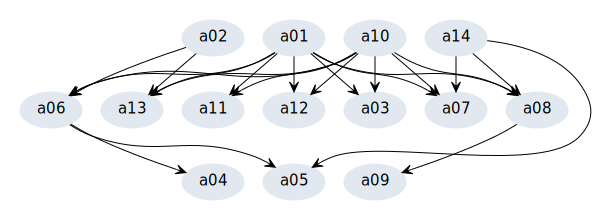

In [33]:
from hassediagram.hasse_diagram import hasse_graphviz
hasse_graphviz(df_relations.values, df.index)

# Standarization

In [37]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# PCA

In [45]:
N_COMPONENTS = 2

pca = PCA(n_components=N_COMPONENTS)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled), index=df.index, columns=range(N_COMPONENTS))
print(pca.explained_variance_ratio_)
df_pca

[0.44298066 0.31153263]


,0,1
a01,0.243925,1.773592
a02,-1.676446,2.325448
a03,1.638356,0.394646
a04,-1.797365,-0.963997
a05,-1.254374,-0.929392
a06,-2.805310,-0.210164
a07,1.928345,-0.871992
a08,0.246307,-1.315961
a09,0.756357,-1.417312
a10,0.405999,2.130835


In [46]:
CRITERIA = [Criterion(name, points=2) for name in df_pca.columns]
df_relations_pca = uta_gms(df_pca, PREFERENCES, CRITERIA)
print(df_relations_pca.sum().sum())
df_relations_pca

62.0


,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14
a01,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
a02,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
a03,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
a04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
a05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
a06,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
a07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
a09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
a10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


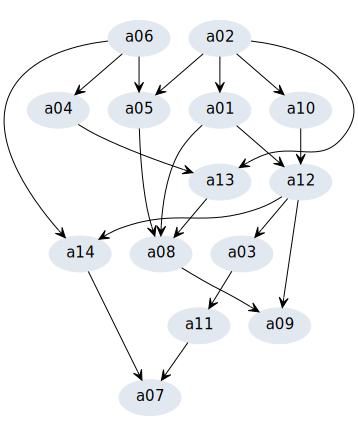

In [47]:
from hassediagram.hasse_diagram import hasse_graphviz
hasse_graphviz(df_relations_pca.values, df.index)

# t-SNE

In [48]:
tsne = TSNE(n_components=N_COMPONENTS, perplexity=10)
df_tsne = pd.DataFrame(tsne.fit_transform(df_scaled), index=df.index, columns=range(N_COMPONENTS))
df_tsne

,0,1
a01,13.291439,-15.414589
a02,-7.297515,-9.496221
a03,32.599518,-22.721209
a04,19.593143,25.731983
a05,22.794508,8.869997
a06,4.691143,16.100023
a07,51.388363,-18.480846
a08,39.820404,-0.819615
a09,53.049259,8.130645
a10,6.334501,-28.709702


In [49]:
CRITERIA = [Criterion(name, points=2) for name in df_tsne.columns]
df_relations_tsne = uta_gms(df_tsne, PREFERENCES, CRITERIA)
print(df_relations_tsne.sum().sum())
df_relations_tsne

98


,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14
a01,1,1,0,1,1,1,0,1,1,0,0,0,1,0
a02,0,1,0,1,1,1,0,0,1,0,0,0,1,0
a03,1,1,1,1,1,1,0,1,1,0,0,0,1,1
a04,0,0,0,1,0,0,0,0,0,0,0,0,0,0
a05,0,0,0,1,1,1,0,0,0,0,0,0,1,0
a06,0,0,0,1,0,1,0,0,0,0,0,0,0,0
a07,1,1,0,1,1,1,1,1,1,0,0,0,1,1
a08,0,0,0,1,1,1,0,1,1,0,0,0,1,0
a09,0,0,0,1,1,1,0,0,1,0,0,0,1,0
a10,1,1,1,1,1,1,0,1,1,1,0,0,1,1


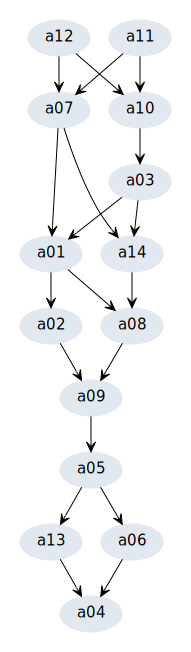

In [50]:
from hassediagram.hasse_diagram import hasse_graphviz
hasse_graphviz(df_relations_tsne.values, df.index)

# MDS

In [52]:
mds = MDS(n_components=N_COMPONENTS)
df_mds = pd.DataFrame(mds.fit_transform(df_scaled), index=df.index, columns=range(N_COMPONENTS))
df_mds

,0,1
a01,-2.045197,-0.432826
a02,-2.115737,-2.665167
a03,-1.242775,1.655565
a04,1.288554,-1.678652
a05,0.869439,-1.186398
a06,0.819393,-2.886677
a07,0.371843,2.367466
a08,1.241879,0.430153
a09,1.558769,1.010697
a10,-2.281645,0.055130


In [53]:
CRITERIA = [Criterion(name, points=2) for name in df_mds.columns]
df_relations_mds = uta_gms(df_mds, PREFERENCES, CRITERIA)
print(df_relations_mds.sum().sum())
df_relations_mds

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
62


,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,a11,a12,a13,a14
a01,1,0,1,0,0,0,1,1,1,0,1,1,0,1
a02,1,1,1,1,1,0,1,1,1,0,1,1,1,1
a03,0,0,1,0,0,0,1,0,0,0,1,0,0,1
a04,0,0,0,1,0,0,0,0,1,0,0,0,1,1
a05,0,0,0,0,1,0,0,1,1,0,0,0,1,1
a06,0,0,0,1,1,1,0,1,1,0,0,0,1,1
a07,0,0,0,0,0,0,1,0,0,0,0,0,0,0
a08,0,0,0,0,0,0,0,1,1,0,0,0,0,1
a09,0,0,0,0,0,0,0,0,1,0,0,0,0,0
a10,0,0,1,0,0,0,1,1,1,1,1,1,0,1


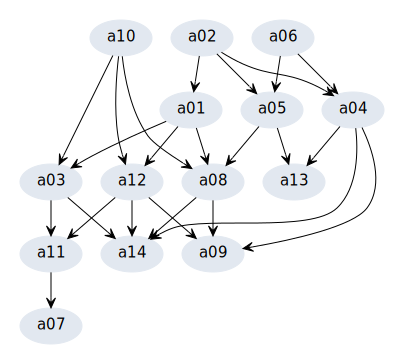

In [54]:
from hassediagram.hasse_diagram import hasse_graphviz
hasse_graphviz(df_relations_mds.values, df.index)